# Demo Script for Milestone 10.15

## 0 Prepare task

### 0.1 prepare planning scene

#### Run camera server on the camera computer (192.168.0.10, use vnc viewer)
```bash
python stream_server.py --ip='192.168.0.10' # camera pc ip
```

#### Run shared detector on bash
```bash
python3 /home/jhkim/Projects/rnb-planning/src/scripts/milestone_202110/utils/shared_detector.py
```

#### Check and request ip setting from mobile udp client (robot-side)

#### 0.1.1 Set parameters and create planning scene

In [1]:
import numpy as np

CONNECT_CAM = True
ENABLE_DETECT = True
ENABLE_O3D = True

CONNECT_INDY = True
CONNECT_MOBILE = True

VISUALIZE = False
VERBOSE = False
PLANNING_MULTIPROC = True
N_AGENTS = 10
NODE_TRIAL_MAX = N_AGENTS

ROS_MASTER_ON_MOBILE = False
# Tool dimensions
TOOL_DIM = [0.08, 0.32]
# TOOL_OFFSET = 0.01
TOOL_OFFSET = 0.0 # tested one
MARGIN = 0
TRACK_THICKNESS = 0.001

INDY_BASE_OFFSET = (0.172,0,0.439)
INDY_BASE_RPY = (0,0,0)
TOOL_NAME = "brush_face"
WALL_THICKNESS = 0.01
CLEARANCE = 0.001

IP_CUR = "192.168.0.8"# get_ip_address()
MOBILE_IP = "192.168.0.102"
INDY_IP = "192.168.0.3"
CAM_HOST = '192.168.0.10'

print("Current PC IP: {}".format(IP_CUR))
print("Mobile ROB IP: {}".format(MOBILE_IP))
print("CAM SERVER IP: {}".format(CAM_HOST))

Current PC IP: 192.168.0.8
Mobile ROB IP: 192.168.0.102
CAM SERVER IP: 192.168.0.10


In [2]:
import os
import sys
sys.path.append(os.path.join(os.path.join(
    os.environ["RNB_PLANNING_DIR"], 'src')))
sys.path.append(os.path.join(
    os.environ["RNB_PLANNING_DIR"], 'src/scripts/milestone_202110'))

from pkg.global_config import RNB_PLANNING_DIR
from pkg.utils.utils import *    
from pkg.utils.rotation_utils import *
from pkg.controller.combined_robot import *
from demo_utils.streaming import *
from demo_utils.detect_table import *
from demo_utils.area_select import *
from pkg.detector.aruco.marker_config import get_aruco_map
aruco_map = get_aruco_map()

from pkg.geometry.builder.scene_builder import SceneBuilder
from demo_utils.environment import *
from demo_utils.area_select import DATASET_DIR, SweepDirections

from utils.streaming import *
from utils.detection_util import *


from pkg.utils.shared_function import *
clear_channels_on("kiromobilemap")

mobile_config = RobotConfig(0, RobotType.kmb, ((0,0,0), (0,0,0)),
                "{}/{}".format(MOBILE_IP, IP_CUR), 
                            specs={"dummy":not CONNECT_MOBILE})
robot_config = RobotConfig(1, RobotType.indy7, 
                           (INDY_BASE_OFFSET, INDY_BASE_RPY),
                INDY_IP, root_on="kmb0_platform", 
                           specs={"no_sdk":True})
MOBILE_NAME = mobile_config.get_indexed_name()
ROBOT_NAME = robot_config.get_indexed_name()
crob = CombinedRobot(robots_on_scene=[mobile_config, robot_config]
              , connection_list=[True, CONNECT_INDY])

s_builder = SceneBuilder(None)
SceneBuilder.autostart_roscore = not ROS_MASTER_ON_MOBILE
gscene = s_builder.create_gscene(crob)

gtems = s_builder.add_robot_geometries(
    color=(1,1,1,0.2), display=True, collision=True)
gscene.set_workspace_boundary(
    -4, 8, -7, 7, -CLEARANCE, 3, thickness=WALL_THICKNESS)


from pkg.planning.scene import PlanningScene
pscene = PlanningScene(gscene, combined_robot=crob)

ROBOT_BASE = pscene.robot_chain_dict[ROBOT_NAME]['link_names'][0]
TIP_LINK = pscene.robot_chain_dict[ROBOT_NAME]["tip_link"]
MOBILE_BASE = pscene.robot_chain_dict[MOBILE_NAME]["tip_link"]
HOLD_LINK = MOBILE_BASE

viewpoint = add_cam(gscene, tool_link=TIP_LINK)
# add_indy_tool_kiro(gscene, tool_link=TIP_LINK, 
# face_name=TOOL_NAME, zoff=TOOL_OFFSET)

HOME_POSE = -crob.home_pose
HOME_DICT = list2dict(HOME_POSE, gscene.joint_names)

from pkg.planning.pipeline import PlanningPipeline
ppline = PlanningPipeline(pscene)

# Set planner
from pkg.planning.motion.moveit.moveit_planner import MoveitPlanner
from pkg.planning.filtering.grasp_filter import GraspChecker
mplan = MoveitPlanner(pscene, enable_dual=False, 
                      incremental_constraint_motion=True)
mplan.motion_filters = [GraspChecker(pscene)]
mplan.update_gscene()
gcheck = GraspChecker(pscene)
mplan.motion_filters = [gcheck]

mplan.reset_PRQdict(enable_PRQ=True, radii=5e-2)
for tip_dir, SWEEP_AXIS in [
    (SweepDirections.front, "Z"), (SweepDirections.front, "X"), (SweepDirections.up, "Z"), (SweepDirections.down, "Z")]:
    filename = SweepDirections.get_file_name(RobotType.indy7, tip_dir.name+SWEEP_AXIS)+"-PRQ.pkl"
    PRQ_PATH = os.path.join(DATASET_DIR, filename)
    try:
        Pos_Rotvec_Qlist_dict = load_pickle(PRQ_PATH)
        mplan.register_PRQ(ROBOT_NAME, Pos_Rotvec_Qlist_dict, decimal=2)
        print("Loaded: {}".format(filename))
    except:
        print("File not exist: {}".format(filename))
        continue

from pkg.planning.task.rrt import TaskRRT
tplan = TaskRRT(pscene, node_trial_max=NODE_TRIAL_MAX)
tplan.prepare()
ppline.set_motion_planner(mplan)
ppline.set_task_planner(tplan)


add_kiro_indytool_down(gscene, zoff=TOOL_OFFSET, 
                       tool_link=TIP_LINK, face_name=TOOL_NAME)

# Register binders
from pkg.planning.constraint.constraint_actor import VacuumTool, \
    Gripper2Tool, PlacePlane, SweepFramer

brush_face = pscene.create_binder(
    bname=TOOL_NAME, gname=TOOL_NAME, _type=SweepFramer, 
    point=(0,0, -gscene.NAME_DICT['brush_face'].dims[2]/2-CLEARANCE), 
    rpy=(0,0,0))

gscene.create_safe(
    gtype=GEOTYPE.BOX, name="floor_box", link_name="base_link",
    dims=(15,15,0.4), center=(0,0,0), rpy=(0,0,0), 
    color=(1, 1, 1, 0.1), display=True, collision=False, fixed=True)

gscene.add_highlight_axis("hl", "base_coord", T=np.identity(4), dims=(0.5,0.1,0.1))

kmb = crob.robot_dict["kmb0"]
indy = crob.robot_dict["indy1"]
mobile_box = gscene.NAME_DICT['kmb0_platform_Box_2']

if CONNECT_MOBILE:
    assert np.sum(np.abs(get_xyzw_cur()))>1e-4, "UDP Server not connected"

connection command:
kmb0: True
indy1: True
[MOBILE ROBOT] bind: ('192.168.0.8', 50306)
[MOBILE ROBOT] Start UDP THREAD
goal reach: 0 -> 1 (1636356647.69)
goal reach signal edge up
Connect: Server IP (192.168.0.3)
Unable to register with master node [http://localhost:11311]: master may not be running yet. Will keep trying.
Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Please create a subscriber to the marker
Loaded: indy7-frontZ-PRQ.pkl
Loaded: indy7-frontX-PRQ.pkl
Loaded: indy7-upZ-PRQ.pkl
Loaded: indy7-downZ-PRQ.pkl


#### 0.1.2 Load environment map

In [3]:
from demo_utils.ros_map_utils import KiroMobileMap
kmm = KiroMobileMap(MOBILE_IP, IP_CUR, CONNECT_MOBILE)
            
VALID_BOX_SCALE = 0.8
VALID_SCORE_CUT = 50
kmb.coster = (lambda Q: 
                  np.max(
                      kmm.get_box_costs(mobile_box, Q, kmm.T_bi, kmm.cost_im, kmm.resolution, 
                                        scale=VALID_BOX_SCALE)))
kmb.cost_cut = VALID_SCORE_CUT

kmm.init_node(timeout=10)

In [4]:
pole_pt_list, pole_res = kmm.update_map(gscene, crob, MOBILE_BASE, timeout=100)

Connect: Server IP (192.168.0.3)
[WARN] Vertices for mesh should be have center point (0,0,0). Auto adjusting.


## 1. Detect scene

### 1.0 Wait task start queue

### 1.1 Detect bed

In [5]:
from utils.shared_detector import SharedDetector
sd = SharedDetector()
if ENABLE_DETECT:
    sd.init()

#### 1.1.1 Move to bed-seek pose 

In [6]:
Q_CUR = kmb.get_qcur()

VIEW_POSE = np.deg2rad([  0., 50.,  -70.,  -0.,  -90., 0])
VIEW_LOC = list(Q_CUR[:6])
VIEW_POSE_EXT = np.array(VIEW_LOC + list(VIEW_POSE))
if CONNECT_INDY:
    with indy:
        indy.joint_move_to(np.rad2deg(VIEW_POSE))
        time.sleep(0.5)
        indy.wait_for_move_finish()
        Qcur = np.deg2rad(indy.get_joint_pos())
else:
    Qcur = VIEW_POSE
gscene.show_pose(VIEW_POSE_EXT)

Connect: Server IP (192.168.0.3)
Move finished!


Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)


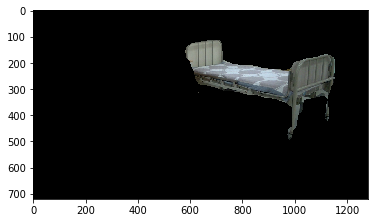

In [7]:
turn_dir = 1
Q0 = np.rad2deg(VIEW_POSE_EXT[6:])
dQ = np.zeros(6)
while True:
    # Take a picture again after rotate
    if CONNECT_CAM:
        rdict = stream_capture_image(
            ImageType.FirstView, obj_type="bed", host=CAM_HOST,
            crob=crob)
    else:
        rdict, VIEW_POSE_EXT = load_rdict("bed")
        

    cdp = rdict2cdp(rdict)
        
    
    if ENABLE_DETECT:
        # Output of inference(mask for detected table)
        mask_out = sd.inference(color_img=rdict['color'])
        cv2.imwrite(os.path.join(SAVE_DIR, "mask_bed.png"), mask_out)
    else:
        mask_out = cv2.imread(os.path.join(SAVE_DIR, "mask_bed.png"))[:,:,0]
        
    if np.any(mask_out):
        cdp_masked = apply_mask(cdp, mask_out)
        plt.imshow(cdp_masked.color[:,:,[2,1,0]])
        break
    if CONNECT_INDY:
        with indy:
            turn_dir *= -1
            dQ = np.add(dQ, [5,0,0,0,0,0])
            Qto = Q0+turn_dir*dQ
            Qto[0] = (Qto[0]+180/2)%180-180/2
            indy.joint_move_to(Qto)
            indy.wait_motion()
            VIEW_POSE_EXT[6:] = np.deg2rad(indy.get_joint_pos())

#### 1.1.2  detect bed and add to the scene

In [8]:
from pkg.utils.utils import *
gtimer = GlobalTimer.instance()

In [9]:
VISUALIZE = False
T_bc = viewpoint.get_tf(VIEW_POSE_EXT)
T_bc_bed_view = np.copy(T_bc)
T_cb = SE3_inv(T_bc)
gscene.show_pose(VIEW_POSE_EXT)
if ENABLE_O3D:
    icp_bed = MultiICP(model=MODEL_DIR + '/bed/bed.STL', 
                       Toff=SE3([[0,1,0],[0,0,1],[1,0,0]], [0.455,0,1.02]))
    # Try ICP1
    if np.any(mask_out):
        pcd = icp_bed.add_image(cdp_masked, Tc=None)

        Tguess = icp_bed.get_initial_by_center(R=np.matmul(T_cb[:3,:3], Rot_axis(3,np.pi)), 
                                               offset=np.matmul(T_cb[:3,:3], (1.1*0.7,0,-0.6)))
        
        with gtimer.block("ICP"):
            Tbs1, fitness1 = icp_bed.compute_ICP(To=Tguess, thres=0.15, visualize=VISUALIZE)
            Tbs2, fitness2 = icp_bed.compute_ICP(None, thres=0.15, visualize=VISUALIZE)
        
    # Better result is adopted
    T_co_bed = Tbs1 if fitness1 > fitness2 else Tbs2
    T_bo_bed = np.matmul(T_bc, T_co_bed)
    
    bed_center = T_bo_bed[:3,3]
    T_bo_new = align_z(T_bo_bed)
    bed_rpy = Rot2rpy(T_bo_new[:3,:3])

    # adjust
    bed_center[2]=0
    if Rot_rpy(bed_rpy)[0,0] > 0:
        bed_rpy[2] += np.pi

    bed_mat = add_bed(gscene, bed_center, bed_rpy, (0,1,0,0.3))
    if VISUALIZE: # show final result
        icp_bed.draw(np.matmul(T_cb, gscene.NAME_DICT["bed_vis"].get_tf(VIEW_POSE_EXT)))
    
else:
    bed_center = (5.1,-0.1,0)
    bed_rpy = (0,0,np.pi)
    bed_mat = add_bed(gscene, bed_center, bed_rpy, (0,1,0,0.3))

bed_vis = gscene.NAME_DICT["bed_vis"]

Apply point-to-point ICP
registration::RegistrationResult with fitness=9.153498e-01, inlier_rmse=7.131947e-02, and correspondence_set size of 28731
Access transformation to get result.
Transformation is:
[[ 0.7845264  -0.06347111  0.61683858 -0.26724556]
 [-0.28286958 -0.92184952  0.26491181 -0.13081695]
 [ 0.55181808 -0.38231517 -0.74116934  4.38741648]
 [ 0.          0.          0.          1.        ]]
:: Downsample with a voxel size 0.040.
:: Estimate normal with search radius 0.080.
:: Compute FPFH feature with search radius 0.240.
:: Downsample with a voxel size 0.040.
:: Estimate normal with search radius 0.080.
:: Compute FPFH feature with search radius 0.240.
Apply point-to-point ICP
registration::RegistrationResult with fitness=0.000000e+00, inlier_rmse=0.000000e+00, and correspondence_set size of 0
Access transformation to get result.
Transformation is:
[[ 0.81579464 -0.25772046  0.51774441 -2.14641486]
 [-0.0607971  -0.92847797 -0.36637735  1.51316472]
 [ 0.57513722  0.2674

In [10]:
# Front ICP - refine the position of bed
VISUALIZE = False
T_bc_new = viewpoint.get_tf(VIEW_POSE_EXT)
T_bo_new = bed_vis.get_tf(VIEW_POSE_EXT)
Tco_guess = np.matmul(SE3_inv(T_bc_bed_view), T_bo_new)
T_cc = np.matmul(SE3_inv(T_bc_bed_view), T_bc_new)

with gtimer.block("ICP"):
    Tbs_f, fitness_f = icp_bed.compute_front_ICP(
        T_cc, To=Tco_guess, thres=0.15, visualize=VISUALIZE)


T_bo_bed = np.matmul(T_bc, Tbs_f)
bed_center = T_bo_bed[:3,3]
T_bo_new = align_z(T_bo_bed)
bed_rpy = Rot2rpy(T_bo_new[:3,:3])

# adjust
bed_center[2]=0
if Rot_rpy(bed_rpy)[0,0] > 0:
    bed_rpy[2] += np.pi
move_bed(gscene, bed_center, bed_rpy)

Apply point-to-point ICP
registration::RegistrationResult with fitness=9.361689e-01, inlier_rmse=5.348814e-02, and correspondence_set size of 14681
Access transformation to get result.
Transformation is:
[[ 0.78760933 -0.04923289  0.61420493 -0.25326216]
 [-0.25142421 -0.93572324  0.24740227 -0.07619571]
 [ 0.56254548 -0.34928235 -0.7493627   4.40833469]
 [ 0.          0.          0.          1.        ]]


### 1.2 Detect Closet

#### 1.2.1  move to full view position

##### calc fule view pose

In [11]:
VIEW_MOVED = np.deg2rad([  0., 50.,  -70.,  -0.,  -80., 0])
# VIEW_MOVED = np.deg2rad([  0., -10.,  -0.,  -0.,  -100., 0])
VIEW_POSE_EXT[crob.idx_dict[ROBOT_NAME]] = VIEW_MOVED

bed_vis = gscene.NAME_DICT["bed_vis"]
T_bo = bed_vis.get_tf(list2dict(VIEW_POSE_EXT, gscene.joint_names))

if ENABLE_O3D:
    h_fov_hf = np.arctan2(cdp.intrins[0], 2*cdp.intrins[2])
    # Determine the location of closet
    CLOSET_LOCATION = check_location_top_table(
        cdp2pcd(cdp), cdp2pcd(cdp_masked), T_bc, T_bo, 
        bed_dims=bed_mat.dims, visualize=False)
    print("CLOSET on {}".format(CLOSET_LOCATION))
else:
    h_fov_hf = np.pi/4
    CLOSET_LOCATION = "LEFT"
    
if CLOSET_LOCATION == "LEFT":
    angle_ref = 145
elif CLOSET_LOCATION == "RIGHT":       
    angle_ref = -145
    
bed_dim = np.linalg.norm(bed_mat.dims)
x_z_ratio = np.tan(h_fov_hf)
bed_dist = (bed_dim/2) / x_z_ratio * 3 
while True:
    angle_view = angle_ref + np.random.uniform(-5, 5)
    dist_view = bed_dist + np.random.uniform(-1, 1)*bed_dist/8
    Tbs = bed_mat.get_tf(VIEW_POSE_EXT)
    Tbs = np.matmul(Tbs, 
                    SE3(np.identity(3), (-bed_mat.dims[0]/2, 0,0)))
    Tsc = np.matmul(SE3(Rot_axis(3, np.deg2rad(angle_view)), (0,)*3), 
                    SE3(np.identity(3), (-dist_view, 0,0)))
    Tbc = np.matmul(Tbs, Tsc)
    Tmc = viewpoint.get_tf(VIEW_POSE_EXT, from_link=MOBILE_BASE)
    Tmc[:3,:3] = np.identity(3)
    Tbm = np.matmul(Tbc, SE3_inv(Tmc))
    full_view_ext = np.copy(VIEW_POSE_EXT)
    full_view_ext[:2] = Tbm[:2,3]
    full_view_ext[2] = Rot2axis(Tbm[:3, :3], 3)
#     gscene.show_pose(full_view_ext)
    res = kmb.check_valid(full_view_ext[:6])
    if res:
        VIEW_MOVED_EXT = full_view_ext
        break

CLOSET on LEFT


##### move to full view pose

In [12]:
if CONNECT_INDY and CONNECT_MOBILE:
    gscene.show_pose(crob.get_real_robot_pose())
    print("real_robot_pose: {}".format(
        np.round(crob.get_real_robot_pose(), 2)))

Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
real_robot_pose: [ 2.13  3.13 -0.54  0.    0.    0.   -0.09  0.87 -1.22 -0.   -1.57  0.  ]


In [13]:
gscene.show_pose(VIEW_MOVED_EXT)

In [14]:
if CONNECT_INDY:
    with indy:
        indy.joint_move_to(np.rad2deg(VIEW_MOVED))
    kmb.joint_move_make_sure(VIEW_MOVED_EXT[:6])
    VIEW_MOVED_EXT = crob.get_real_robot_pose()
if not CONNECT_INDY:
    VIEW_MOVED_EXT[6:] = VIEW_MOVED.copy()
gscene.show_pose(VIEW_MOVED_EXT)
print("VIEW_MOVED_EXT: {}".format(
    np.round(VIEW_MOVED_EXT, 2)))

Connect: Server IP (192.168.0.3)
Send to mobile: [ 2.134  3.135 -0.265  0.964]
             -> [ 2.487  2.5   -0.296  0.955  0.   ]
Distance=0.729204609429 ([ 0.352 -0.635 -0.065])
goal reach: 1 -> 0 (1636356674.46)
goal reach: 0 -> 1 (1636356687.84)
goal reach signal edge up
End up at=[ 2.477  2.471 -0.645] (0.0534 / 0.0534)
Connect: Server IP (192.168.0.3)
VIEW_MOVED_EXT: [ 2.48  2.47 -0.64  0.    0.    0.   -0.    0.87 -1.22  0.   -1.4  -0.  ]


#### 1.2.2 redetect bed

Connect: Server IP (192.168.0.3)
Apply point-to-point ICP
registration::RegistrationResult with fitness=9.293492e-01, inlier_rmse=5.791830e-02, and correspondence_set size of 50354
Access transformation to get result.
Transformation is:
[[ 1.62232306e-02  4.72971217e-03 -9.99857218e-01  5.76851128e+00]
 [-9.96633921e-01  8.04457023e-02 -1.57903914e-02  5.70786933e-01]
 [ 8.03595321e-02  9.96747771e-01  6.01888076e-03 -2.42409133e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


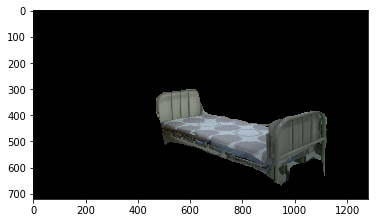

In [15]:
VISUALIZE = False
T_bc = viewpoint.get_tf(VIEW_MOVED_EXT)
# capture image of full view
if CONNECT_CAM:
    rdict = stream_capture_image(
        ImageType.FullView, obj_type="full_view", host=CAM_HOST,
        crob=crob)
    
else:
    rdict, VIEW_MOVED_EXT = load_rdict("full_view")
    T_bc = viewpoint.get_tf(VIEW_MOVED_EXT)
    gscene.show_pose(VIEW_MOVED_EXT)
    
cdp = rdict2cdp(rdict)

if ENABLE_DETECT:
    # Output of inference(mask for detected table)
    mask_out = sd.inference(color_img=cdp.color)
    cv2.imwrite(os.path.join(SAVE_DIR, "mask_bed_re.png"), mask_out)
else:
    mask_out = cv2.imread(os.path.join(SAVE_DIR, "mask_bed_re.png"))[:,:,0]
    
if np.any(mask_out):
    cdp_masked = apply_mask(cdp, mask_out)
    plt.imshow(cdp_masked.color[:,:,[2,1,0]])

    icp_bed.clear()
    pcd = icp_bed.add_image(cdp_masked, Tc=T_bc)
    T_bs_pre = gscene.NAME_DICT["bed_vis"].get_tf(VIEW_MOVED_EXT)
    T_bo_bed, fitness = icp_bed.compute_ICP(To=T_bs_pre, thres=0.12, visualize=VISUALIZE)
#         # front_ICP
#         T_bo_bed, fitness = icp_bed.compute_front_ICP(T_bc, To=T_bs_pre, thres=0.12, visualize=VISUALIZE)
    # adjust
    T_bo_bed[2]=0
    T_bo_bed[:3, :3]=Rot_axis(3, Rot2axis(T_bo_bed[:3, :3], 3))
    move_bed(gscene, T_bo_bed[:3,3], Rot2rpy(T_bo_bed[:3,:3]))

    if VISUALIZE: # show final result
        icp_bed.draw(gscene.NAME_DICT["bed_vis"].get_tf(VIEW_MOVED_EXT))
else:
    raise(RuntimeError("bed not detected"))

#### 1.2.3  detect and add closet

In [16]:
VISUALIZE = False
if ENABLE_O3D:
    icp_closet = MultiICP(model=MODEL_DIR + '/top_table/top_table.STL', 
                       Toff=SE3([[1,0,0],[0,0,1],[0,-1,0]], [0.3,0,0.2725]))
    
    if CONNECT_CAM:
        rdict = stream_capture_image(ImageType.FirstView, obj_type="top_table", host=CAM_HOST,
                                     crob=crob)
    else:
        rdict, VIEW_MOVED_EXT = load_rdict("top_table")

    T_bc = viewpoint.get_tf(VIEW_MOVED_EXT)
    
    cdp = rdict2cdp(rdict)
    pcd_closet = cdp2pcd(cdp, T_bc)
    
    
    pcd_masked = mask_boxes(pcd_closet, 
                        boxes=[gscene.NAME_DICT["bed_{}_space".format(CLOSET_LOCATION.lower())]], 
                        Q=VIEW_MOVED_EXT, inside=True, 
                        merge_rule=np.all, link_ref="base_link")
    pcd_masked = mask_boxes(pcd_masked, 
                        boxes=[gscene.NAME_DICT["bed_box"], 
                               gscene.NAME_DICT["bed_wall"], 
                               gscene.NAME_DICT["floor_box"]], 
                        Q=VIEW_MOVED_EXT, inside=False, 
                        merge_rule=np.all, link_ref="base_link")
    pcd_masked, ind = pcd_masked.remove_radius_outlier(nb_points=20, radius=0.06)
    icp_closet.add_pointcloud(pcd_masked, T_bc, ratio=0.5)
    
    Tbs = bed_vis.get_tf(VIEW_MOVED_EXT)
    initial_guess = icp_closet.get_initial_by_median(
        Tbs[:3, :3], 
        np.matmul(T_bc[:3,:3], (0,0,0.3))-(0,0,1))
    with gtimer.block("ICP"):
        T_bo, fitness = icp_closet.compute_front_ICP(T_bc, initial_guess, thres=0.05, visualize=VISUALIZE)
    
#     # front_cut_ICP
#     T_bo, fitness = icp_closet.compute_front_cut_ICP("closet",
#                            initial_guess, thres=0.05, visualize=VISUALIZE)
    
    #adjust
    T_bo[2]=0
    T_bo[:3, :3]=Rot_axis(3, Rot2axis(T_bo[:3, :3], 3))
#     gscene.show_point_cloud(pcd_closet.points, "allpoints", color=(0,0,0,0.5), dims=(0.01,0.01,0.01), sample_to=500)
#     gscene.show_point_cloud(pcd_masked.points, "masked", color=(1,0,0,1), dims=(0.02,0.02,0.02))
else:
    T_bo = T_xyzrpy((np.matmul(Rot_rpy(bed_rpy), (-0.75,-1.5,0))+bed_center, 
                     bed_rpy))
    
closet_leftup, closet_rightup, closet_down = add_closet(
    gscene, closet_center=T_bo[:3,3], closet_rpy=Rot2rpy(T_bo[:3,:3]), 
    COLOR_CLOSET_COL=(0,1,0,0.3))

add_backwall(gscene)

Connect: Server IP (192.168.0.3)
Apply point-to-point ICP
registration::RegistrationResult with fitness=6.359118e-01, inlier_rmse=1.701918e-02, and correspondence_set size of 14074
Access transformation to get result.
Transformation is:
[[-9.99858482e-01  4.02912530e-04  1.68194390e-02  5.78836553e+00]
 [ 1.68228858e-02  3.67395190e-02  9.99183286e-01  7.56335302e-01]
 [-2.15354633e-04  9.99324795e-01 -3.67410979e-02  3.77009067e-02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [17]:
pole_pt_list = kmm.remove_poles_by_box(gscene, gscene.NAME_DICT["bed_box"], 
                    pole_pt_list, VIEW_POSE_EXT)
pole_pt_list = kmm.remove_poles_by_box(gscene, gscene.NAME_DICT["closet_box"], 
                    pole_pt_list, VIEW_POSE_EXT)
pole_pt_list = kmm.remove_poles_by_box(gscene, gscene.NAME_DICT["room_box"], 
                    pole_pt_list, VIEW_POSE_EXT, inside=False)
pole_list = kmm.add_pixel_poles("obs_pt", gscene, pole_pt_list, pole_res)
gcheck.ignore_always = pole_list

gscene.update_markers_all() 

In [18]:
from pkg.ui.ui_broker import *

# start UI
ui_broker = UIBroker.instance()
ui_broker.initialize(ppline, s_builder)
ui_broker.start_server()

ui_broker.set_tables()

Dash is running on http://0.0.0.0:8050/

 * Serving Flask app "pkg.ui.dash_launcher" (lazy loading)
 * Environment: production



## 2. Closet cleaning

### 2.0. Prepare functions

In [19]:
from pkg.planning.constraint.constraint_common import *
from pkg.planning.constraint.constraint_actor import *
from pkg.planning.constraint.constraint_subject import *
from pkg.utils.code_scraps import get_look_motion

   Use a production WSGI server instead.
 * Debug mode: off


In [20]:
# mplan.reset_log(flag_log=True)
Q_CUR = VIEW_MOVED_EXT
HOME_POSE_SWEEP = np.copy(Q_CUR)
# HOME_POSE_SWEEP[6:] = 0
crob.home_pose = HOME_POSE_SWEEP
crob.home_dict = list2dict(crob.home_pose, 
                           gscene.joint_names)
floor_ws = gscene.NAME_DICT["floor_ws"]    

brush_face = change_tool(
    pscene, kmb, ToolDir.down, TOOL_OFFSET, TIP_LINK, 
    TOOL_NAME, SweepFramer, clearance=CLEARANCE)

Tool Down


In [21]:
adjust_count_list = []
def look_closet_get_offset(gxter, crob, mplan, robot_name, Qref):
    Qref_in = np.copy(Qref)
    Qref = np.copy(Qref)
    for _ in range(5):
        traj, succ = get_look_motion(mplan, robot_name, Qref, 
                                     target_point=gscene.NAME_DICT["closet_leftup"],
                                     com_link=pscene.robot_chain_dict[robot_name]['link_names'][-1],
                                     view_dir=[0,0,1],timeout=1)
        traj_rev = np.array(list(reversed(traj)))

    if not succ:
        look_closet_get_offset.Qref_fail = Qref
        raise(RuntimeError("Get Look Motion Fail"))

    Qref[6:] = traj[-1][6:]
    gscene.show_pose(Qref)
    if CONNECT_INDY:
        with indy: # move to look
            crob.move_joint_traj(traj, one_by_one=True)

    time.sleep(1)

    icp_closet = MultiICP(model=MODEL_DIR + '/top_table/top_table.STL', 
                       Toff=SE3([[1,0,0],[0,0,1],[0,-1,0]], [0.3,0,0.2725]))

    adjust_count_list.append(1)
    if CONNECT_CAM:
        rdict = stream_capture_image(ImageType.FirstView, 
                                     obj_type="closet_{}".format(len(adjust_count_list)), 
                                     host=CAM_HOST, crob=crob)
    else:
        try:
            rdict, Qref = load_rdict("closet_{}".format(len(adjust_count_list)))
            gscene.show_pose(Qref)
        except Exception as e:
            TextColors.YELLOW.println("[WARN] out of saved look refine data")
            print(e)
            Qcur = np.copy(Qref_in)
            Qcur[:6] = Qref_in[:6] + np.random.uniform([-0.05, -0.05, -0.05, 0, 0, 0],
                                                         [0.05, 0.05, 0.05, 0, 0, 0])

            Qtar = np.copy(Qref_in)
            Qtar[:6] = Qref_in[:6] + np.random.uniform([-0.05, -0.05, -0.05, 0, 0, 0],
                                                         [0.05, 0.05, 0.05, 0, 0, 0])
            return Qcur, Qtar

    T_bc, T_bs_closet = viewpoint.get_tf(Qref), gscene.NAME_DICT["closet_vis"].get_tf(Qref)

    cdp = rdict2cdp(rdict)
    pcd_closet = cdp2pcd(cdp, T_bc)

    with gtimer.block("masking"):
        pcd_masked = mask_boxes(pcd_closet, 
                            boxes=[gscene.NAME_DICT["closet_box"]], 
                            Q=Qref, inside=True, 
                            merge_rule=np.all, link_ref="base_link")
        pcd_masked = mask_boxes(pcd_masked, 
                            boxes=[gscene.NAME_DICT["bed_box"], 
                                   gscene.NAME_DICT["bed_wall"], 
                                   gscene.NAME_DICT["floor_box"],
                                   gscene.NAME_DICT["back_wall"]], 
                            Q=Qref, inside=False, 
                            merge_rule=np.all, link_ref="base_link")

    with gtimer.block("adding"):
        icp_closet.add_pointcloud(pcd_masked, T_bc)

    initial_guess = gscene.NAME_DICT["closet_vis"].get_tf(Qref)
    with gtimer.block("compute_front_ICP"):
        # front_ICP
        T_bo_close, fitness = icp_closet.compute_front_ICP(
            T_bc, initial_guess, thres=0.05, visualize=VISUALIZE)

    # calculate transform based on obtained points
    pcd_center_prev = pcd_masked.get_center()

    T_bo_p = SE3(T_bo_close[:3,:3], pcd_center_prev)
    T_pooc = np.matmul(SE3_inv(T_bo_p), T_bo_close)
    T_bo_p[:3,:3] = Rot_axis(3, Rot2axis(T_bo_close[:3,:3], 3))
    T_bo_c_fix = np.matmul(T_bo_p, T_pooc)
    T_bo_c_fix[2,3] = 0

    # get Twoff from redetection
    Tbo0, Tbo1 = T_bs_closet, T_bo_c_fix
    Tbw0 = gscene.get_tf(gxter.mobile_link, Qref)
    Tow1 = np.matmul(SE3_inv(Tbo1), Tbw0)
    Tbw1 = np.matmul(Tbo0, Tow1)

    if CONNECT_CAM and CONNECT_MOBILE:
        Qcur = np.copy(Qref)
        Qcur[:2] = Tbw1[:2,3]
        Qcur[2] = Rot2axis(Tbw1[:3,:3], 3)

        Tow0 = np.matmul(SE3_inv(Tbo0), Tbw0)
        Tbw1tar = np.matmul(Tbo1, Tow0)
        Qtar = np.copy(Qref)
        Qtar[:2] = Tbw1tar[:2,3]
        Qtar[2] = Rot2axis(Tbw1tar[:3,:3], 3)
    else:
        Qcur = np.copy(Qref_in)
        Qcur[:6] = Qref_in[:6] + np.random.uniform([-0.05, -0.05, -0.05, 0, 0, 0],
                                                     [0.05, 0.05, 0.05, 0, 0, 0])
        
        Qtar = np.copy(Qref_in)
        Qtar[:6] = Qref_in[:6] + np.random.uniform([-0.05, -0.05, -0.05, 0, 0, 0],
                                                     [0.05, 0.05, 0.05, 0, 0, 0])
    return Qcur, Qtar

### 2.1. Greedily execute closet cleaning

In [22]:
VISUALIZE = False

In [23]:
VEL_LEVEL = 3

if CONNECT_INDY:
    with indy:
        vel_level_bak = indy.get_joint_vel_level()
        print("vel_level_bak: {}".format(vel_level_bak))

    with indy:
        indy.set_joint_vel_level(VEL_LEVEL)
        
    indy.collision_policy = POLICY_NO_COLLISION_DETECTION
swp_fin_list = []

Qcur = VIEW_MOVED_EXT
mode_switcher=ModeSwitcherKMB(pscene, push_dist=0.0)

Connect: Server IP (192.168.0.3)
vel_level_bak: 5
Connect: Server IP (192.168.0.3)


In [24]:
gtimer.reset(scale=1, timeunit='s', stack=True)
gscene.add_virtual_guardrail(
    closet_leftup, HEIGHT=0.2, margin=0.1)
gxter = GreedyExecuter(ppline, brush_face, TOOL_DIM, Qcur)
gxter.set_test_kwargs(multiprocess=PLANNING_MULTIPROC, N_agents=N_AGENTS,
                           timeout=0.3, timeout_loop=5.0, verbose=VERBOSE)
gxter.get_division_dict(closet_leftup, "up", "Z", None)
gxter.init_base_divs(Qcur)
snode_schedule_list_lu, Qcur, covereds = gxter.greedy_execute(Qcur, 1, mode_switcher, look_closet_get_offset)
gxter.test_clear()
print(gtimer)

[INFO] Approach through: [ 3.99  1.52 -0.06] (1) -> [ 4.09  1.36 -0.06] (41)
Send to mobile: [ 1.995  2.324 -0.254  0.967]
             -> [ 3.988  1.524 -0.028  1.     0.   ]
Distance=2.19633858388 ([ 1.993 -0.8    0.459])
goal reach: 1 -> 0 (1636351038.74)
goal reach: 0 -> 1 (1636351051.73)
goal reach signal edge up
End up at=[ 4.038  1.52  -0.026] (0.0576 / 0.0576)
Send to mobile: [ 4.038  1.52  -0.013  1.   ]
             -> [ 4.087  1.357 -0.028  1.     0.   ]
Distance=2.34934951103 ([ 2.091 -0.967  0.459])
goal reach: 1 -> 0 (1636351052.84)
goal reach: 0 -> 1 (1636351057.54)
goal reach signal edge up
End up at=[ 4.098  1.339 -0.013] (0.0469 / 0.0469)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Move finished!
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.646034e-01, inlier_rmse=1.539771e-02, and corresp

======================= terminated 8: required answers acquired  (1.2/5.0) ===============================
========================== FINISHED (0.0 / 5.0 s) ==============================]
[PLAN] Try idc (2,)
terminate_on_first is deprecated. Use max_solution_count=1
Use 10/36 agents
Goal reached
Goal reached
======================= terminated 0: required answers acquired  (0.8/5.0) ===============================
Goal reached
======================= terminated 2: required answers acquired  (0.9/5.0) ===============================
Goal reached
======================= terminated 4: required answers acquired  (0.9/5.0) ===============================
Goal reached
======================= terminated 5: required answers acquired  (0.9/5.0) ===============================
======================= terminated 1: required answers acquired  (0.9/5.0) ===============================
Goal reached
======================= terminated 7: required answers acquired  (1.0/5.0) ===========================

Goal reached
======================= terminated 6: required answers acquired  (1.0/5.0) ===============================
Goal reached
======================= terminated 4: required answers acquired  (1.0/5.0) ===============================
Goal reached
======================= terminated 7: required answers acquired  (1.0/5.0) ===============================
Goal reached
======================= terminated 8: required answers acquired  (1.0/5.0) ===============================
Goal reached
======================= terminated 9: required answers acquired  (1.1/5.0) ===============================
========================== FINISHED (0.0 / 5.0 s) ==============================]
Goal reached
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Move finished!
Connect: Server IP (192.168.0.3)
binder: brush_face
rname: indy1
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168

In [25]:
gtimer.reset(scale=1, timeunit='s', stack=True)
brush_face = change_tool(pscene, kmb, ToolDir.up, TOOL_OFFSET, TIP_LINK, TOOL_NAME, SweepFramer, clearance=CLEARANCE)
gxter_u = GreedyExecuter(ppline, brush_face, TOOL_DIM, Qcur, drift=gxter.drift)
gxter_u.set_test_kwargs(multiprocess=PLANNING_MULTIPROC, N_agents=N_AGENTS,
                           timeout=0.3, timeout_loop=5.0, verbose=VERBOSE)
gxter_u.get_division_dict(closet_leftup, "front", "Z", None)
gxter_u.init_base_divs(Qcur)
gxter.mark_tested(None, None, covereds, [])
snode_schedule_list_lf, Qcur, covereds = gxter_u.greedy_execute(Qcur, 1, mode_switcher, look_closet_get_offset)
brush_face = change_tool(pscene, kmb, ToolDir.down, TOOL_OFFSET, TIP_LINK, TOOL_NAME, SweepFramer, clearance=CLEARANCE)
gxter_u.test_clear()
gscene.clear_virtuals()
print(gtimer)

Tool UP
Send to mobile: [ 4.341  1.213 -0.005  1.   ]
             -> [ 4.282  1.103 -0.03   1.     1.   ]
Distance=0.134113372801 ([-0.059 -0.11  -0.05 ])
goal reach: 1 -> 0 (1636351148.92)
goal reach: 0 -> 1 (1636351152.32)
goal reach signal edge up
End up at=[ 4.27   1.095 -0.09 ] (0.0331 / 0.0331)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Move finished!
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.816033e-01, inlier_rmse=1.407731e-02, and correspondence_set size of 12985
Access transformation to get result.
Transformation is:
[[-9.99684749e-01 -1.57781879e-02  1.95309707e-02  5.87186737e+00]
 [ 1.89134839e-02  3.83797752e-02  9.99084221e-01  6.78475761e-01]
 [-1.65133328e-02  9.99138650e-01 -3.80692555e-02  5.04347711e-03]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[PLAN] Curr

In [26]:
gtimer.reset(scale=1, timeunit='s', stack=True)
gscene.add_virtual_guardrail(
    closet_rightup, HEIGHT=0.2, margin=0.03)
gxter = GreedyExecuter(ppline, brush_face, TOOL_DIM, Qcur, drift=gxter_u.drift)
gxter.set_test_kwargs(multiprocess=PLANNING_MULTIPROC, N_agents=N_AGENTS,
                           timeout=0.3, timeout_loop=5.0, verbose=VERBOSE)

gxter.get_division_dict(closet_rightup, "up", "Z", None)
gxter.init_base_divs(Qcur)
snode_schedule_list_ru, Qcur, covereds = gxter.greedy_execute(Qcur, 1, mode_switcher, look_closet_get_offset)
gxter.test_clear()
gscene.clear_virtuals()
print(gtimer)

Send to mobile: [ 4.269  1.096 -0.045  0.999]
             -> [ 4.454  1.045 -0.024  1.     0.   ]
Distance=0.19562421974 ([ 0.185 -0.05   0.041])
goal reach: 1 -> 0 (1636351186.02)
goal reach: 0 -> 1 (1636351190.72)
goal reach signal edge up
End up at=[4.455 1.049 0.033] (0.0814 / 0.0814)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Move finished!
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.732374e-01, inlier_rmse=1.556109e-02, and correspondence_set size of 16689
Access transformation to get result.
Transformation is:
[[-0.99237175 -0.02929874  0.1197493   5.83109733]
 [ 0.11858569  0.03867142  0.99219049  0.51758736]
 [-0.0337008   0.99882236 -0.03490201  0.04172316]
 [ 0.          0.          0.          1.        ]]
[PLAN] Current position is closer to other Tsm_key. Try switch ((1.87, -0.11, 0.87), (-

In [27]:
gtimer.reset(scale=1, timeunit='s', stack=True)
gscene.add_virtual_guardrail(
    closet_down, HEIGHT=0.2, margin=0.15)
gxter = GreedyExecuter(ppline, brush_face, TOOL_DIM, Qcur, drift=gxter.drift)
tplan.node_trial_max = NODE_TRIAL_MAX * 2
gxter.set_test_kwargs(multiprocess=PLANNING_MULTIPROC, N_agents=N_AGENTS,
                           timeout=0.3, timeout_loop=5.0, verbose=VERBOSE)

gxter.get_division_dict(closet_down, "down", "Z", None)
gxter.init_base_divs(Qcur)
snode_schedule_list_d, Qcur, covereds = gxter.greedy_execute(Qcur, -1, mode_switcher, look_closet_get_offset)
gxter.test_clear()
gscene.clear_virtuals()
print(gtimer)

Send to mobile: [4.455 1.049 0.016 1.   ]
             -> [ 4.223  1.052 -0.034  0.999  0.   ]
Distance=0.252438816219 ([-0.232  0.003 -0.101])
goal reach: 1 -> 0 (1636351239.41)
goal reach: 0 -> 1 (1636351245.11)
goal reach signal edge up
End up at=[ 4.247  1.074 -0.044] (0.04 / 0.04)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Move finished!
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Apply point-to-point ICP
registration::RegistrationResult with fitness=1.819091e-01, inlier_rmse=1.442348e-02, and correspondence_set size of 12909
Access transformation to get result.
Transformation is:
[[-9.97950659e-01 -1.69266353e-02  6.17088172e-02  5.81225069e+00]
 [ 6.09050756e-02  4.44755961e-02  9.97152195e-01  5.69451948e-01]
 [-1.96229680e-02  9.98867063e-01 -4.33535324e-02 -3.47129097e-05]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
[PLAN] Current position is 

Goal reached
Goal reached
======================= terminated 0: required answers acquired  (1.7/5.0) ===============================
Goal reached
======================= terminated 1: required answers acquired  (1.7/5.0) ===============================
Goal reached
======================= terminated 3: required answers acquired  (1.8/5.0) ===============================
Goal reached
======================= terminated 2: required answers acquired  (1.8/5.0) ===============================
Goal reached
Goal reached
======================= terminated 7: required answers acquired  (1.9/5.0) ===============================
======================= terminated 6: required answers acquired  (1.9/5.0) ===============================
Goal reached
======================= terminated 4: required answers acquired  (1.9/5.0) ===============================
Goal reached
======================= terminated 8: required answers acquired  (1.9/5.0) ===============================
Goal reached
==============

======================= terminated 4: node queue empty 5th  (1.7/5.0) ===============================
======================= terminated 3: node queue empty 4th  (1.7/5.0) ===============================
======================= terminated 5: node queue empty 6th  (1.8/5.0) ===============================
======================= terminated 6: node queue empty 7th  (1.8/5.0) ===============================
======================= terminated 7: node queue empty 8th  (1.8/5.0) ===============================
======================= terminated 8: node queue empty 9th  (1.8/5.0) ===============================
======================= terminated 9: node queue empty 10th  (1.8/5.0) ===============================
========================== FINISHED (0.0 / 5.0 s) ==============================]
[PLAN] Try idc (3, 5)
terminate_on_first is deprecated. Use max_solution_count=1
Use 10/36 agents
======================= terminated 1: node queue empty 1th  (1.6/5.0) ===============================
===

======================= terminated 8: node queue empty 9th  (1.8/5.0) ===============================
======================= terminated 9: node queue empty 10th  (1.8/5.0) ===============================
========================== FINISHED (0.0 / 5.0 s) ==============================]
[PLAN] Try idc (5,)
terminate_on_first is deprecated. Use max_solution_count=1
Use 10/36 agents
======================= terminated 0: node queue empty 2th  (1.6/5.0) ===============================
======================= terminated 1: node queue empty 1th  (1.6/5.0) ===============================
======================= terminated 2: node queue empty 3th  (1.7/5.0) ===============================
======================= terminated 4: node queue empty 4th  (1.7/5.0) ===============================
======================= terminated 3: node queue empty 5th  (1.7/5.0) ===============================
======================= terminated 5: node queue empty 6th  (1.7/5.0) ===============================
=====

======================= terminated 0: node queue empty 2th  (1.7/5.0) ===============================
======================= terminated 2: node queue empty 3th  (1.7/5.0) ===============================
======================= terminated 3: node queue empty 4th  (1.7/5.0) ===============================
======================= terminated 4: node queue empty 5th  (1.7/5.0) ===============================
======================= terminated 6: node queue empty 6th  (1.8/5.0) ===============================
======================= terminated 5: node queue empty 7th  (1.8/5.0) ===============================
======================= terminated 7: node queue empty 10th  (1.8/5.0) ===============================
======================= terminated 9: node queue empty 9th  (1.8/5.0) ===============================
======================= terminated 8: node queue empty 8th  (1.8/5.0) ===============================
========================== FINISHED (0.0 / 5.0 s) ==============================]

========================== FINISHED (0.0 / 5.0 s) ==============================]
[PLAN] Line idc [3, 5]
[PLAN] Try idc (3, 5)
terminate_on_first is deprecated. Use max_solution_count=1
Use 10/36 agents
======================= terminated 0: node queue empty 1th  (1.6/5.0) ===============================
======================= terminated 1: node queue empty 2th  (1.6/5.0) ===============================
======================= terminated 2: node queue empty 3th  (1.7/5.0) ===============================
======================= terminated 3: node queue empty 4th  (1.7/5.0) ===============================
======================= terminated 4: node queue empty 5th  (1.7/5.0) ===============================
======================= terminated 5: node queue empty 6th  (1.7/5.0) ===============================
======================= terminated 6: node queue empty 7th  (1.8/5.0) ===============================
======================= terminated 7: node queue empty 8th  (1.8/5.0) =============

======================= terminated 2: node queue empty 3th  (1.7/5.0) ===============================
======================= terminated 3: node queue empty 4th  (1.7/5.0) ===============================
======================= terminated 4: node queue empty 5th  (1.7/5.0) ===============================
======================= terminated 5: node queue empty 6th  (1.7/5.0) ===============================
======================= terminated 6: node queue empty 7th  (1.8/5.0) ===============================
======================= terminated 7: node queue empty 8th  (1.8/5.0) ===============================
======================= terminated 8: node queue empty 9th  (1.8/5.0) ===============================
======================= terminated 9: node queue empty 10th  (1.8/5.0) ===============================
========================== FINISHED (0.0 / 5.0 s) ==============================]
Goal reached
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (19

## 3. Bed cleaning

In [24]:
BED_OFFSET = 0.06

brush_face = change_tool(pscene, kmb, ToolDir.down, 
                         TOOL_OFFSET + BED_OFFSET, 
                         TIP_LINK, TOOL_NAME, 
                         SweepFramer, clearance=CLEARANCE)

T_e_brush = brush_face.get_tf_handle(crob.home_dict, from_link=TIP_LINK)
T_brush_e = SE3_inv(T_e_brush)
EE_HEIGHT = round(bed_mat.get_tf(HOME_DICT)[2,3] + bed_mat.dims[2]/2, 5) \
                + T_brush_e[2, 3] - INDY_BASE_OFFSET[2]

Tool Down


In [26]:
gtimer.reset(scale=1, timeunit='s', stack=True)
gxter = GreedyExecuter(ppline, brush_face, TOOL_DIM, Qcur, 
                       drift=None)
#                        drift=gxter.drift)
gxter.set_test_kwargs(multiprocess=PLANNING_MULTIPROC, N_agents=N_AGENTS,
                           timeout=0.5, timeout_loop=5.0, verbose=VERBOSE)

covereds_all = []
# for _ in range(2):
gxter.get_division_dict(bed_mat, "front", "X", EE_HEIGHT, xout_cut=True)
gxter.init_base_divs(Qcur)
# gxter.mark_tested(None, None, covereds_all, [])
snode_schedule_list_d, Qcur, covereds = gxter.greedy_execute(Qcur, 1, mode_switcher, look_closet_get_offset)
covereds_all = sorted(set(covereds_all+covereds))
gxter.test_clear()
len_covered, len_all = len(covereds_all), len(gxter.surface_div_centers)
# print("########################### TRIAL ONCE DONE ( {} / {} )########################".format(len_covered, len_all))
# if len_covered >= len_all:
#     break
print(gtimer)

('Height Reference: ', 0.5620000252723694)
[PLAN] Skip ((-0.0, -1.146, -0.66), (0.0, 0.0, 0.707, 0.707)) - collision base position
Drift = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[INFO] Approach through: [ 4.53 -1.15  1.59] (95.0) -> [ 4.72 -1.05  1.59] (102.799987793)
[INFO] Approach through: [ 4.54 -1.17  1.59] (66.0) -> [ 4.53 -1.15  1.59] (95.0)
[INFO] Approach through: [ 4.42 -1.18  1.59] (66.0) -> [ 4.54 -1.17  1.59] (66.0)
Send to mobile: [ 2.486  2.475 -0.317  0.948]
             -> [ 4.419 -1.175  0.713  0.701  0.   ]
Distance=4.69442486521 ([ 1.933 -3.65   2.231])
goal reach: 1 -> 0 (1636356755.32)
goal reach: 0 -> 1 (1636356784.11)
goal reach signal edge up
End up at=[ 4.426 -1.128  1.589] (0.0479 / 0.0479)
Send to mobile: [ 4.426 -1.128  0.713  0.701]
             -> [ 4.538 -1.17   0.713  0.701  0.   ]
Distance=4.74085007269 ([ 2.052 -3.645  2.231])
goal reach: 1 -> 0 (1636356785.32)
goal reach: 0 -> 1 (1636356789.01)
goal reach signal edge up
End up at=[ 4.558 -1.171  1.591

======================= terminated 5: node queue empty 3th  (1.2/5.0) ===============================
======================= terminated 4: node queue empty 4th  (1.2/5.0) ===============================
======================= terminated 6: node queue empty 4th  (1.2/5.0) ===============================
======================= terminated 7: node queue empty 5th  (1.2/5.0) ===============================
======================= terminated 8: node queue empty 6th  (1.2/5.0) ===============================
Goal reached
Goal reached
======================= terminated 2: required answers acquired  (1.3/5.0) ===============================
Goal reached
======================= terminated 9: required answers acquired  (1.4/5.0) ===============================
======================= terminated 1: required answers acquired  (1.4/5.0) ===============================
========================== FINISHED (0.0 / 5.0 s) ==============================]
[PLAN] Line idc [7, 8]
[PLAN] Try idc (7, 8)
ter

Goal reached
======================= terminated 4: required answers acquired  (1.0/5.0) ===============================
Goal reached
======================= terminated 7: required answers acquired  (1.0/5.0) ===============================
Goal reached
======================= terminated 9: required answers acquired  (1.0/5.0) ===============================
Goal reached
======================= terminated 8: required answers acquired  (1.1/5.0) ===============================
========================== FINISHED (0.0 / 5.0 s) ==============================]
[PLAN] Try idc (7,)
terminate_on_first is deprecated. Use max_solution_count=1
Use 10/36 agents
======================= terminated 0: node queue empty 1th  (1.4/5.0) ===============================
======================= terminated 1: node queue empty 2th  (1.4/5.0) ===============================
======================= terminated 3: node queue empty 4th  (1.4/5.0) ===============================
======================= terminated 2

========================== FINISHED (0.0 / 5.0 s) ==============================]
[PLAN] Try idc (11,)
terminate_on_first is deprecated. Use max_solution_count=1
Use 10/36 agents
Goal reached
Goal reached
======================= terminated 1: required answers acquired  (0.9/5.0) ===============================
Goal reached
Goal reached
======================= terminated 2: required answers acquired  (0.9/5.0) ===============================
======================= terminated 6: required answers acquired  (0.9/5.0) ===============================
Goal reached
======================= terminated 4: required answers acquired  (0.9/5.0) ===============================
Goal reached
======================= terminated 7: required answers acquired  (0.9/5.0) ===============================
======================= terminated 0: required answers acquired  (1.0/5.0) ===============================
Goal reached
======================= terminated 5: required answers acquired  (1.0/5.0) =============

Goal reached
======================= terminated 7: required answers acquired  (1.3/5.0) ===============================
Goal reached
======================= terminated 9: required answers acquired  (1.4/5.0) ===============================
Goal reached
======================= terminated 0: required answers acquired  (1.4/5.0) ===============================
Goal reached
Goal reached
======================= terminated 3: required answers acquired  (1.5/5.0) ===============================
======================= terminated 5: required answers acquired  (1.5/5.0) ===============================
Goal reached
======================= terminated 6: required answers acquired  (1.5/5.0) ===============================
Goal reached
======================= terminated 8: required answers acquired  (1.6/5.0) ===============================
========================== FINISHED (0.0 / 5.0 s) ==============================]
[PLAN] Line idc [17]
[PLAN] Try idc (17,)
terminate_on_first is deprecated. Us

Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Move finished!
Connect: Server IP (192.168.0.3)
binder: brush_face
rname: indy1
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Move finished!
Connect: Server IP (192.168.0.3)
binder: brush_face
rname: indy1
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Move finished!
Connect: Server IP (192.168.0.3)
binder: brush_face
rname: indy1
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Connect: Server IP (192.168.0.3)
Move finished!
Connect: Server IP (192.168.0.3)
binder: brush_face
rname: indy1
Connect: Server IP (192.168.0.3)
[INFO] Depart via: [ 4.66 -1.16  1.6 ] (95.0) <- [ 4.88 -0.99  1.6 ] (104.0)
Send to mobile: [ 4.876 -0.995  0.719  0.695]
             -> [ 4.656 -1.15

Goal reached
======================= terminated 6: required answers acquired  (1.3/5.0) ===============================
Goal reached
======================= terminated 1: required answers acquired  (1.3/5.0) ===============================
Goal reached
Goal reached
Goal reached
======================= terminated 7: required answers acquired  (1.3/5.0) ===============================
======================= terminated 4: required answers acquired  (1.3/5.0) ===============================
======================= terminated 8: required answers acquired  (1.3/5.0) ===============================
Goal reached
======================= terminated 9: required answers acquired  (1.4/5.0) ===============================
======================= terminated 5: required answers acquired  (1.4/5.0) ===============================
Goal reached
======================= terminated 0: required answers acquired  (1.4/5.0) ===============================
Goal reached
======================= terminated 2: re

======================= terminated 5: node queue empty 7th  (1.3/5.0) ===============================
======================= terminated 7: node queue empty 6th  (1.3/5.0) ===============================
======================= terminated 8: node queue empty 8th  (1.3/5.0) ===============================
======================= terminated 9: node queue empty 9th  (1.4/5.0) ===============================
======================= terminated 0: node queue empty 10th  (1.5/5.0) ===============================
========================== FINISHED (0.0 / 5.0 s) ==============================]
[PLAN] Try idc (9,)
terminate_on_first is deprecated. Use max_solution_count=1
Use 10/36 agents
Goal reached
Goal reached
======================= terminated 2: required answers acquired  (0.9/5.0) ===============================
Goal reached
======================= terminated 3: required answers acquired  (0.9/5.0) ===============================
Goal reached
Goal reached
======================= terminat

Goal reached
Goal reached
======================= terminated 9: required answers acquired  (1.0/5.0) ===============================
======================= terminated 8: required answers acquired  (1.0/5.0) ===============================
========================== FINISHED (0.0 / 5.0 s) ==============================]
[PLAN] Line idc [15, 16]
[PLAN] Try idc (15, 16)
terminate_on_first is deprecated. Use max_solution_count=1
Use 10/36 agents
Goal reached
Goal reached
======================= terminated 1: required answers acquired  (1.2/5.0) ===============================
Goal reached
======================= terminated 4: required answers acquired  (1.3/5.0) ===============================
Goal reached
======================= terminated 5: required answers acquired  (1.3/5.0) ===============================
======================= terminated 2: required answers acquired  (1.3/5.0) ===============================
Goal reached
======================= terminated 7: required answers acqui

goal reach: 1 -> 0 (1636357091.61)
goal reach: 0 -> 1 (1636357124.69)
goal reach signal edge up
End up at=[ 5.108 -1.144  1.576] (0.0358 / 0.0358)
Send to mobile: [ 5.108 -1.144  0.709  0.705]
             -> [ 5.048 -1.181  0.708  0.706  0.   ]
Distance=4.2522897147 ([ 0.717 -2.778 -3.139])
goal reach: 1 -> 0 (1636357126.01)
goal reach: 0 -> 1 (1636357128.16)
goal reach signal edge up
End up at=[ 5.032 -1.195  1.572] (0.0209 / 0.0209)
Send to mobile: [ 5.032 -1.195  0.708  0.707]
             -> [ 5.09  -1.136  0.708  0.706  0.   ]
Distance=4.23051539569 ([ 0.759 -2.733 -3.139])
goal reach: 1 -> 0 (1636357129.39)
goal reach: 0 -> 1 (1636357131.56)
goal reach signal edge up
End up at=[ 5.094 -1.131  1.569] (0.00869 / 0.00869)
Send to mobile: [ 5.094 -1.131  0.707  0.708]
             -> [ 5.01  -1.024  0.708  0.706  0.   ]
Distance=4.01063005022 ([ 0.595 -2.429 -3.135])
goal reach: 1 -> 0 (1636357132.77)
goal reach: 0 -> 1 (1636357136.36)
goal reach signal edge up
End up at=[ 4.998 -1.